In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor
import pymannkendall as mk
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [2]:
# read processed data from pkl file
pkl_file = open('NH_winter_temp_anom.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)

# recover the original values by adding the climatology
with xr.open_dataset(path_ + pre_ + '1980.nc') as ds:
    climatology = ds.climatology.values[:,-90:,:]

doy_l = [0, 31, 59, 304, 334]
doy_r = [31, 59, 90, 334, 365]
ll = [0, 31, 59, 90, 120, 151]
for yy in range(40):
    for mm in range(5):
        il, ir = 151*yy + ll[mm], 151*yy + ll[mm+1]
        temp[il:ir,:,:] += climatology[doy_l[mm]:doy_r[mm],:,:]

temp = temp[90:-61,:,:]

In [3]:
temp_climatology = np.mean(temp, axis=0)
temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

mask = 1 - np.isnan(np.mean(temp, axis=0))
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [4]:
swe_gridded = np.loadtxt('swe_gridded_1deg.txt')
swe_insitu = np.loadtxt('swe_insitu_1deg.txt')

comp_gridded = []
comp_insitu = []

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue
        if swe_gridded[i,j] > 4:
            continue
        
    
        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], temp_mean[:,i,j])
        mk_res1 = mk.original_test(temp_mean[:,i,j])
        
        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], temp_median[:,i,j])
        mk_res2 = mk.original_test(temp_median[:,i,j])


        comp_gridded.append((lm1.coef_[0]*10, lm2.coef_[0]*10, swe_gridded[i,j]))
        if swe_insitu[i,j] != 0:
            comp_insitu.append((lm1.coef_[0]*10, lm2.coef_[0]*10, swe_insitu[i,j]))
        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

comp_gridded = np.array(comp_gridded)
comp_insitu = np.array(comp_insitu)
        

Processing  1000  grids. Time taken so far:  20.160585641860962
Processing  2000  grids. Time taken so far:  40.936519622802734
Processing  3000  grids. Time taken so far:  61.6955304145813
Processing  4000  grids. Time taken so far:  82.39019799232483
Processing  5000  grids. Time taken so far:  104.21328926086426
Processing  6000  grids. Time taken so far:  126.40746784210205
Processing  7000  grids. Time taken so far:  149.21054530143738


In [5]:
_, rho_mean_gridded, rho_median_gridded, rho_diff_gridded = np.corrcoef([comp_gridded[:,2], comp_gridded[:,0], comp_gridded[:,1], comp_gridded[:,1] - comp_gridded[:,0] ])[0,:]
_, rho_mean_insitu, rho_median_insitu, rho_diff_insitu = np.corrcoef([comp_insitu[:,2], comp_insitu[:,0], comp_insitu[:,1], comp_insitu[:,1] - comp_insitu[:,0] ])[0,:]

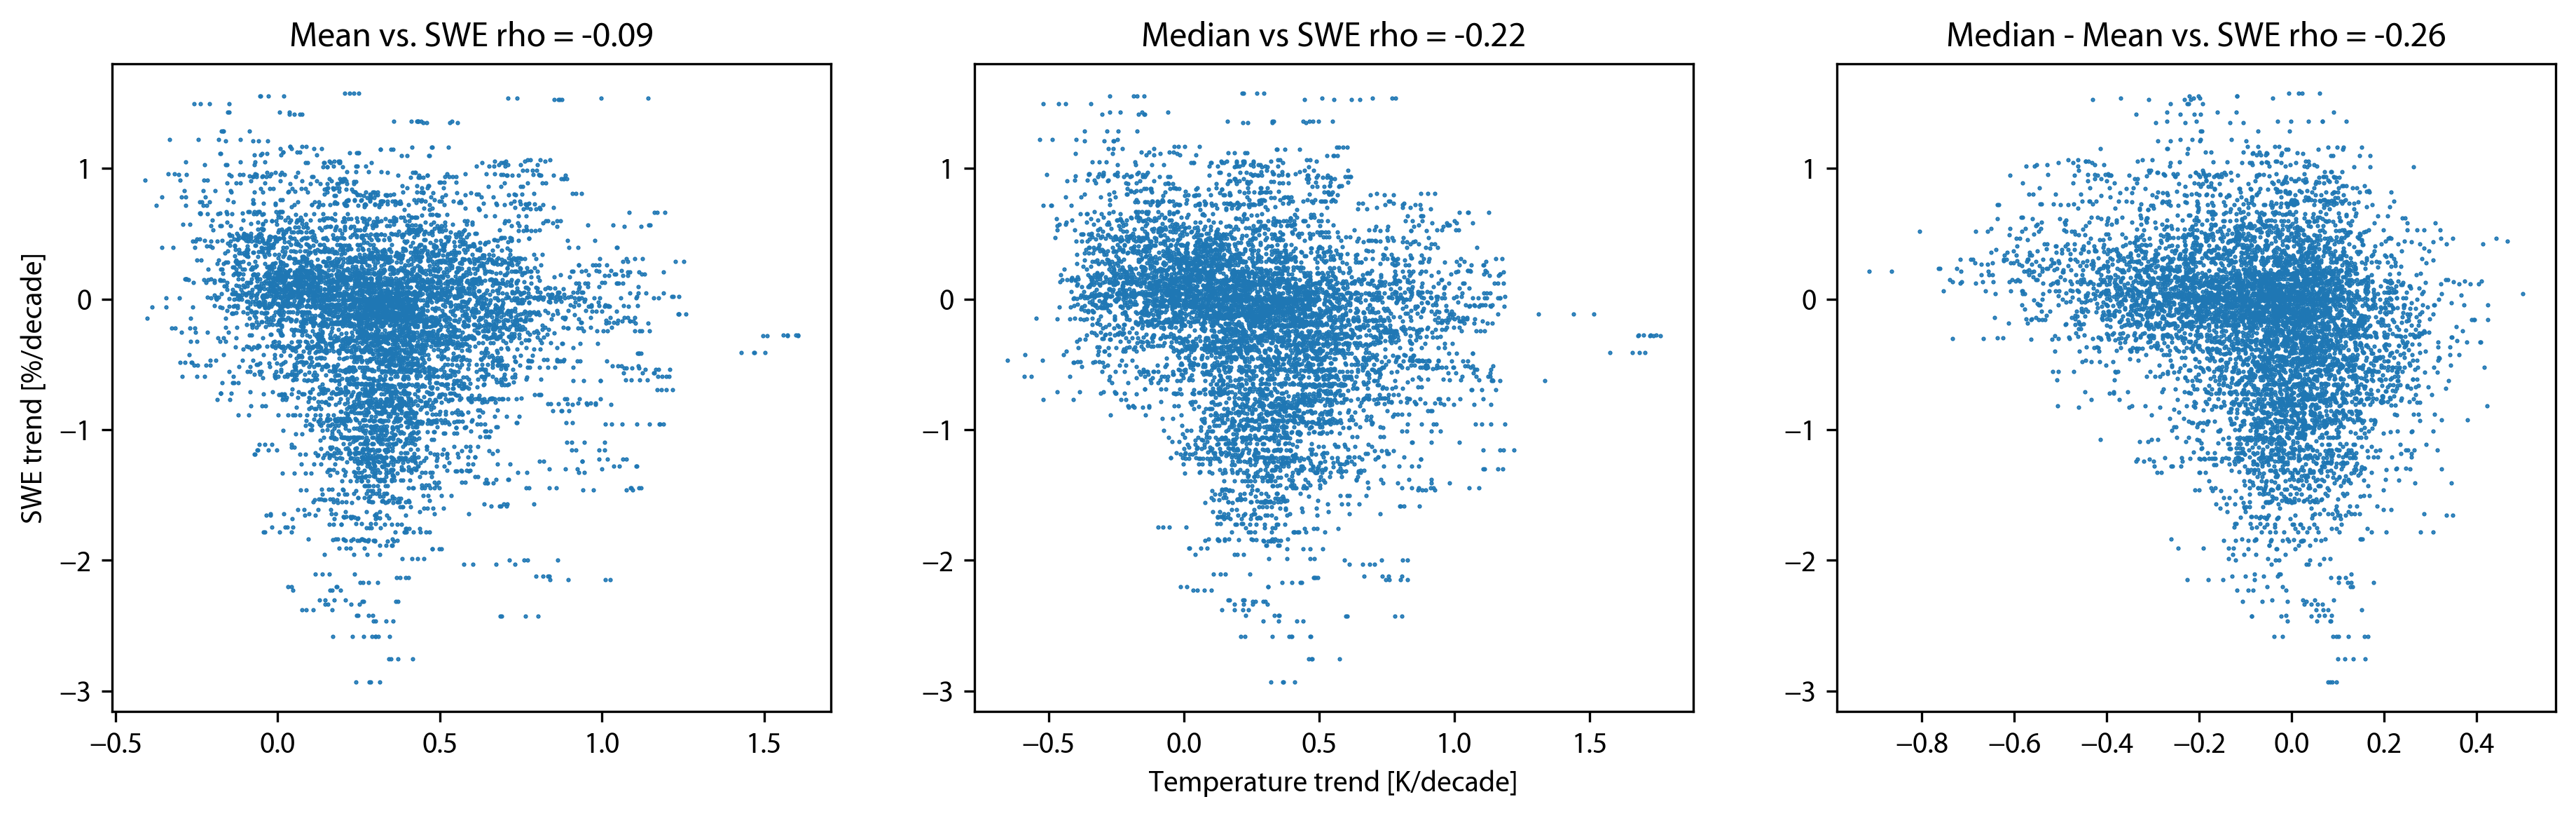

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].scatter(comp_gridded[:,0], comp_gridded[:,2], s=1, marker='.')
ax[0].set_title('Mean vs. SWE rho = {:.2f}'.format(rho_mean_gridded))
ax[0].set_ylabel('SWE trend [%/decade]')
ax[1].scatter(comp_gridded[:,1], comp_gridded[:,2], s=1, marker='.')
ax[1].set_title('Median vs SWE rho = {:.2f}'.format(rho_median_gridded))
ax[1].set_xlabel('Temperature trend [K/decade]')
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_gridded))
ax[2].scatter(comp_gridded[:,1] - comp_gridded[:,0], comp_gridded[:,2], s=1, marker='.')


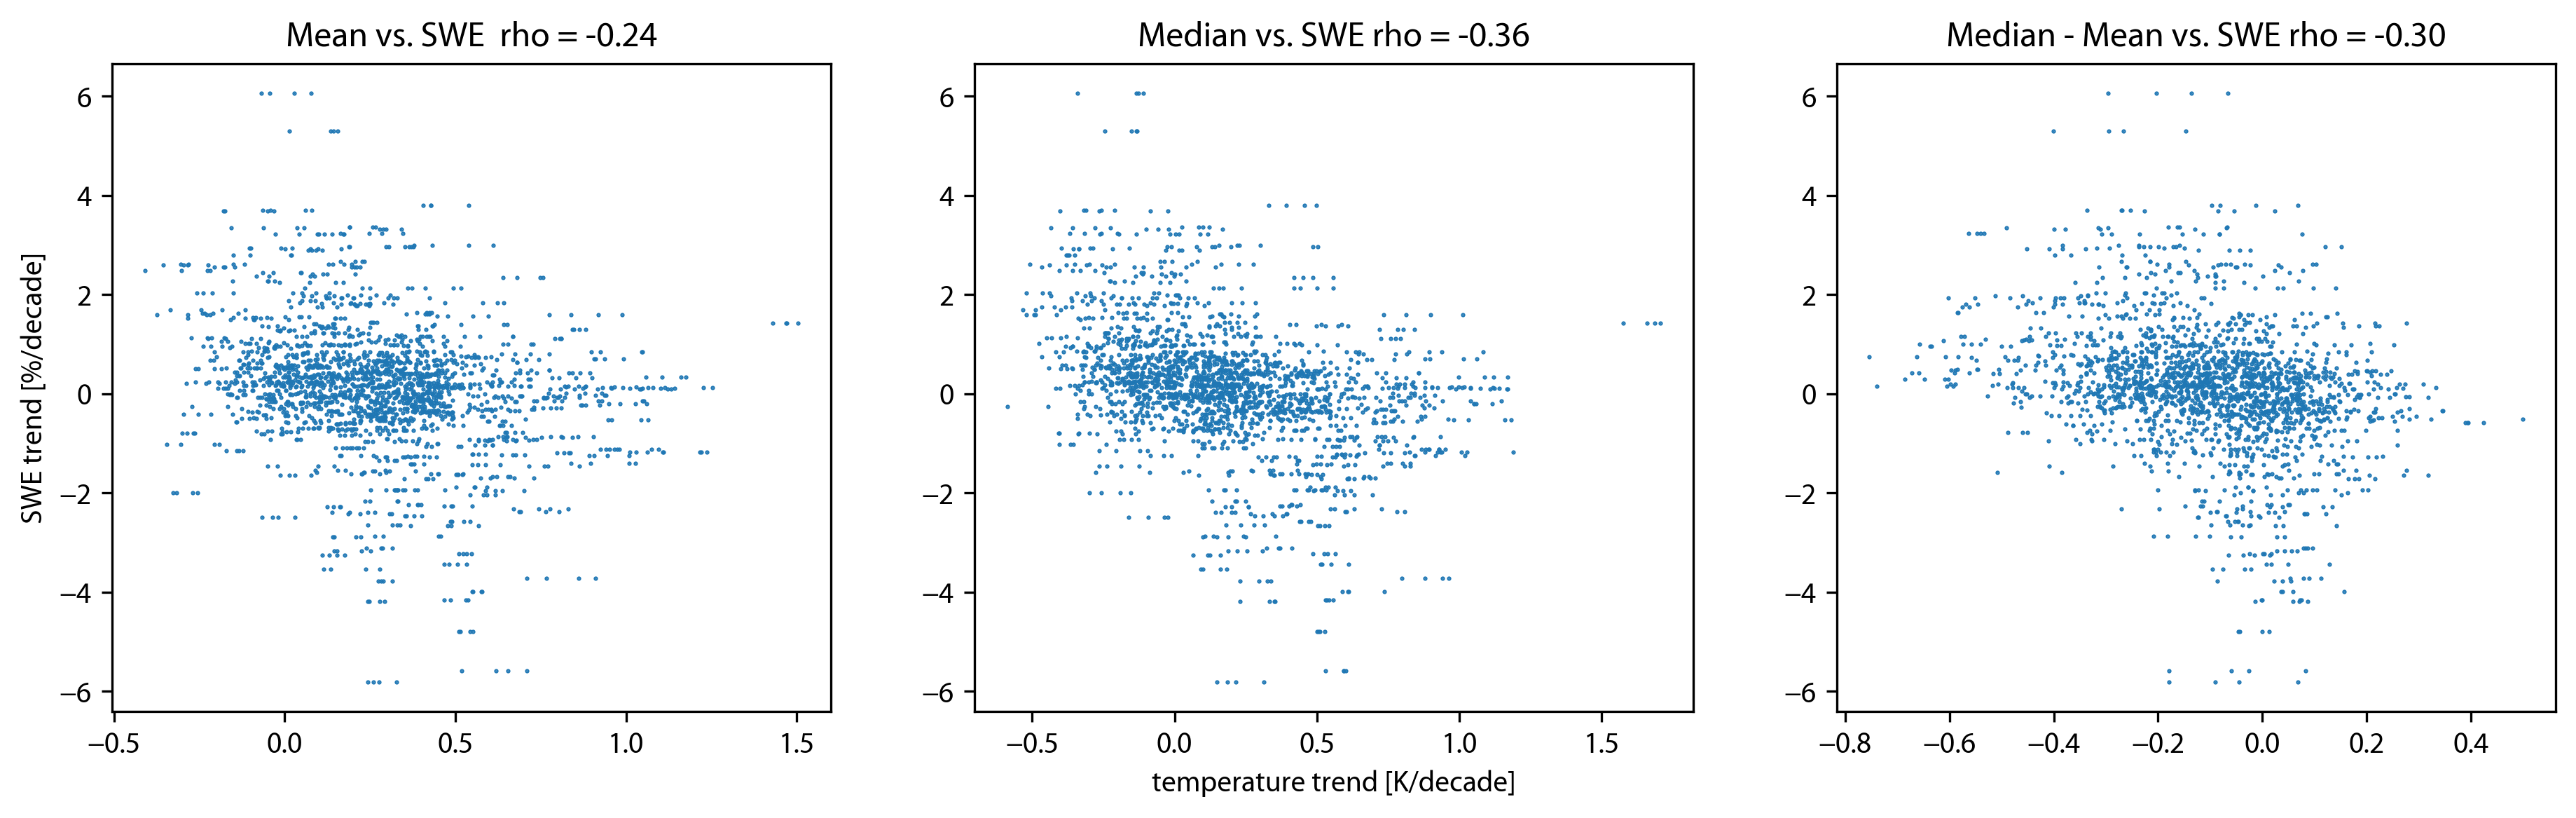

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].scatter(comp_insitu[:,0], comp_insitu[:,2], s=1, marker='.')
ax[0].set_title('Mean vs. SWE  rho = {:.2f}'.format(rho_mean_insitu))
ax[0].set_ylabel('SWE trend [%/decade]')
ax[1].scatter(comp_insitu[:,1], comp_insitu[:,2], s=1, marker='.')
ax[1].set_title('Median vs. SWE rho = {:.2f}'.format(rho_median_insitu))
ax[1].set_xlabel('temperature trend [K/decade]')
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_insitu))
ax[2].scatter(comp_insitu[:,1] - comp_insitu[:,0], comp_insitu[:,2], s=1, marker='.')

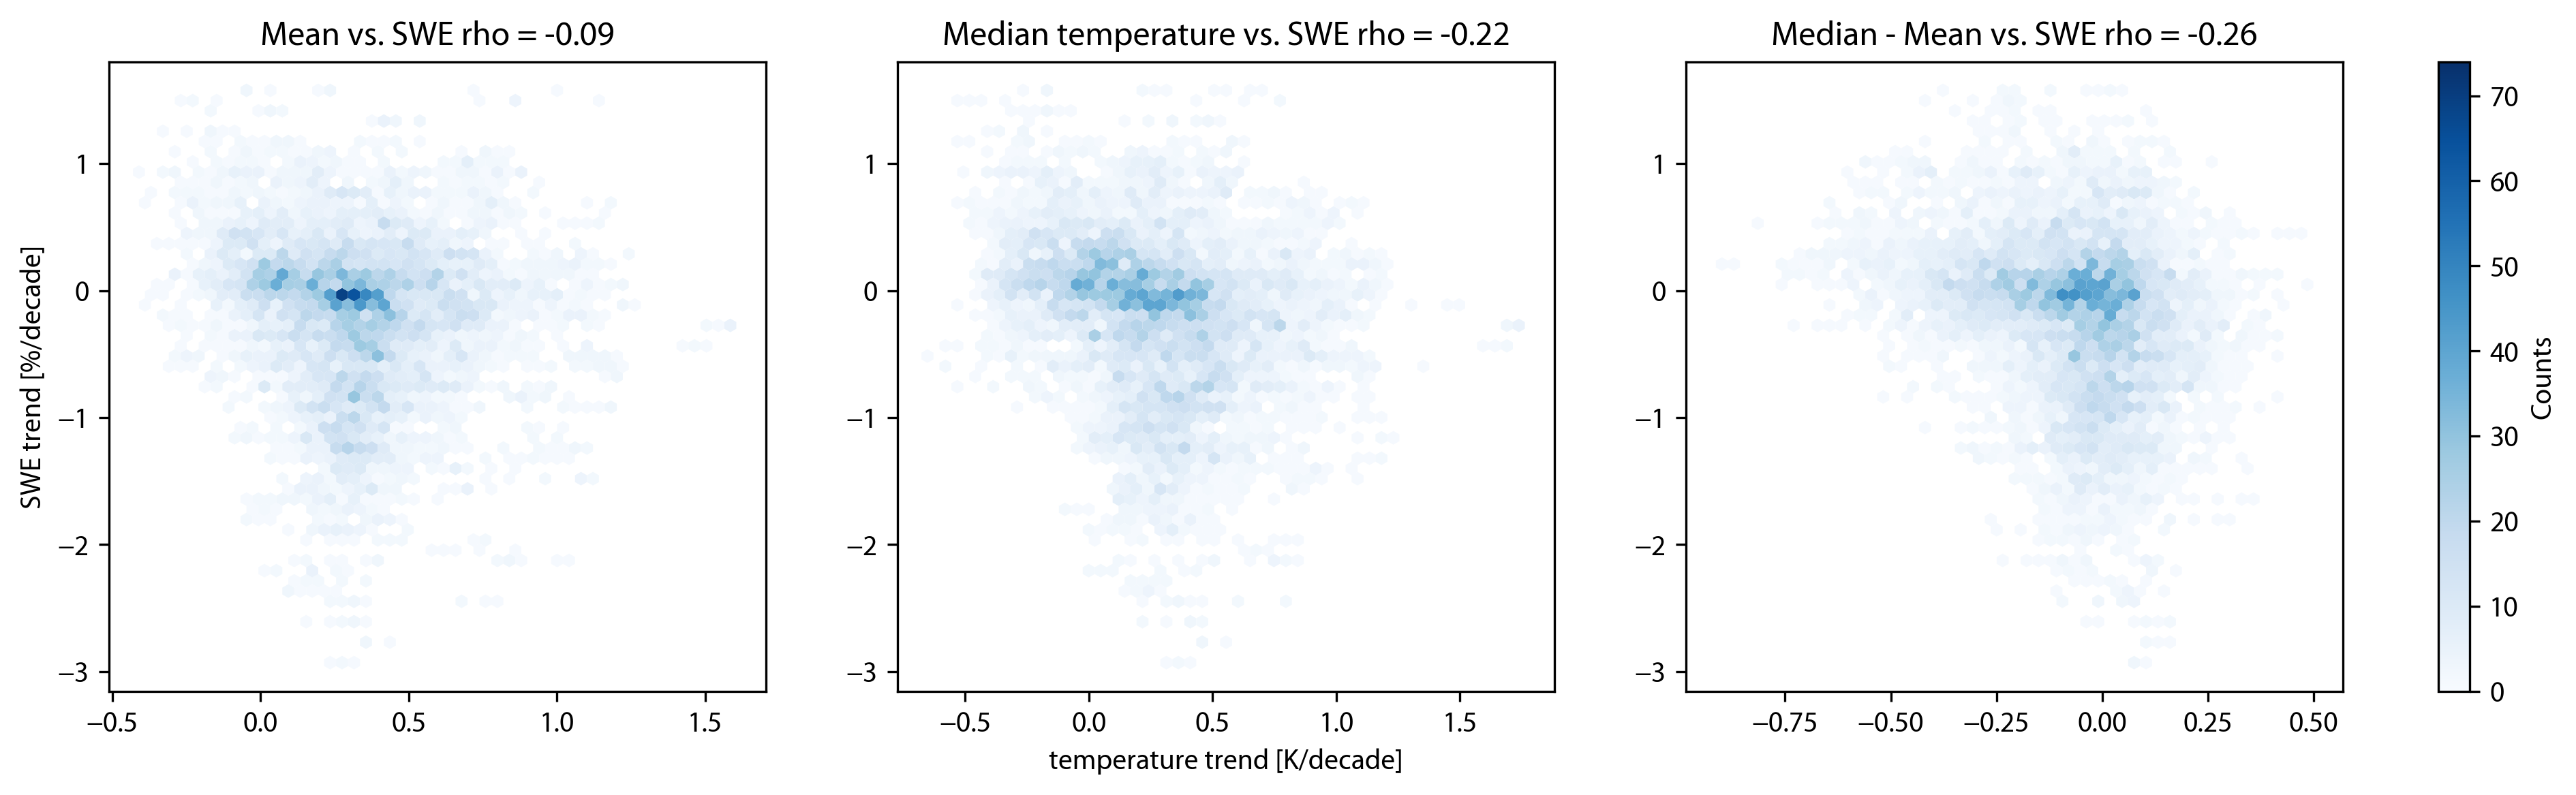

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

combined_density = np.concatenate([
    np.histogram2d(comp_gridded[:, 0], comp_gridded[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_gridded[:, 1], comp_gridded[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_gridded[:, 1] - comp_gridded[:, 0], comp_gridded[:, 2], bins=50)[0].flatten()
])

max_density = combined_density.max()

hb = ax[0].hexbin(comp_gridded[:,0], comp_gridded[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[0].set_title('Mean vs. SWE rho = {:.2f}'.format(rho_mean_gridded))
ax[0].set_ylabel('SWE trend [%/decade]')

hb = ax[1].hexbin(comp_gridded[:,1], comp_gridded[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[1].set_title('Median temperature vs. SWE rho = {:.2f}'.format(rho_median_gridded))
ax[1].set_xlabel('temperature trend [K/decade]')

hb = ax[2].hexbin(comp_gridded[:,1] - comp_gridded[:,0], comp_gridded[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_gridded))

# Add a single colorbar for all plots
cbar = fig.colorbar(hb, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Counts')

# plt.tight_layout()
plt.show()

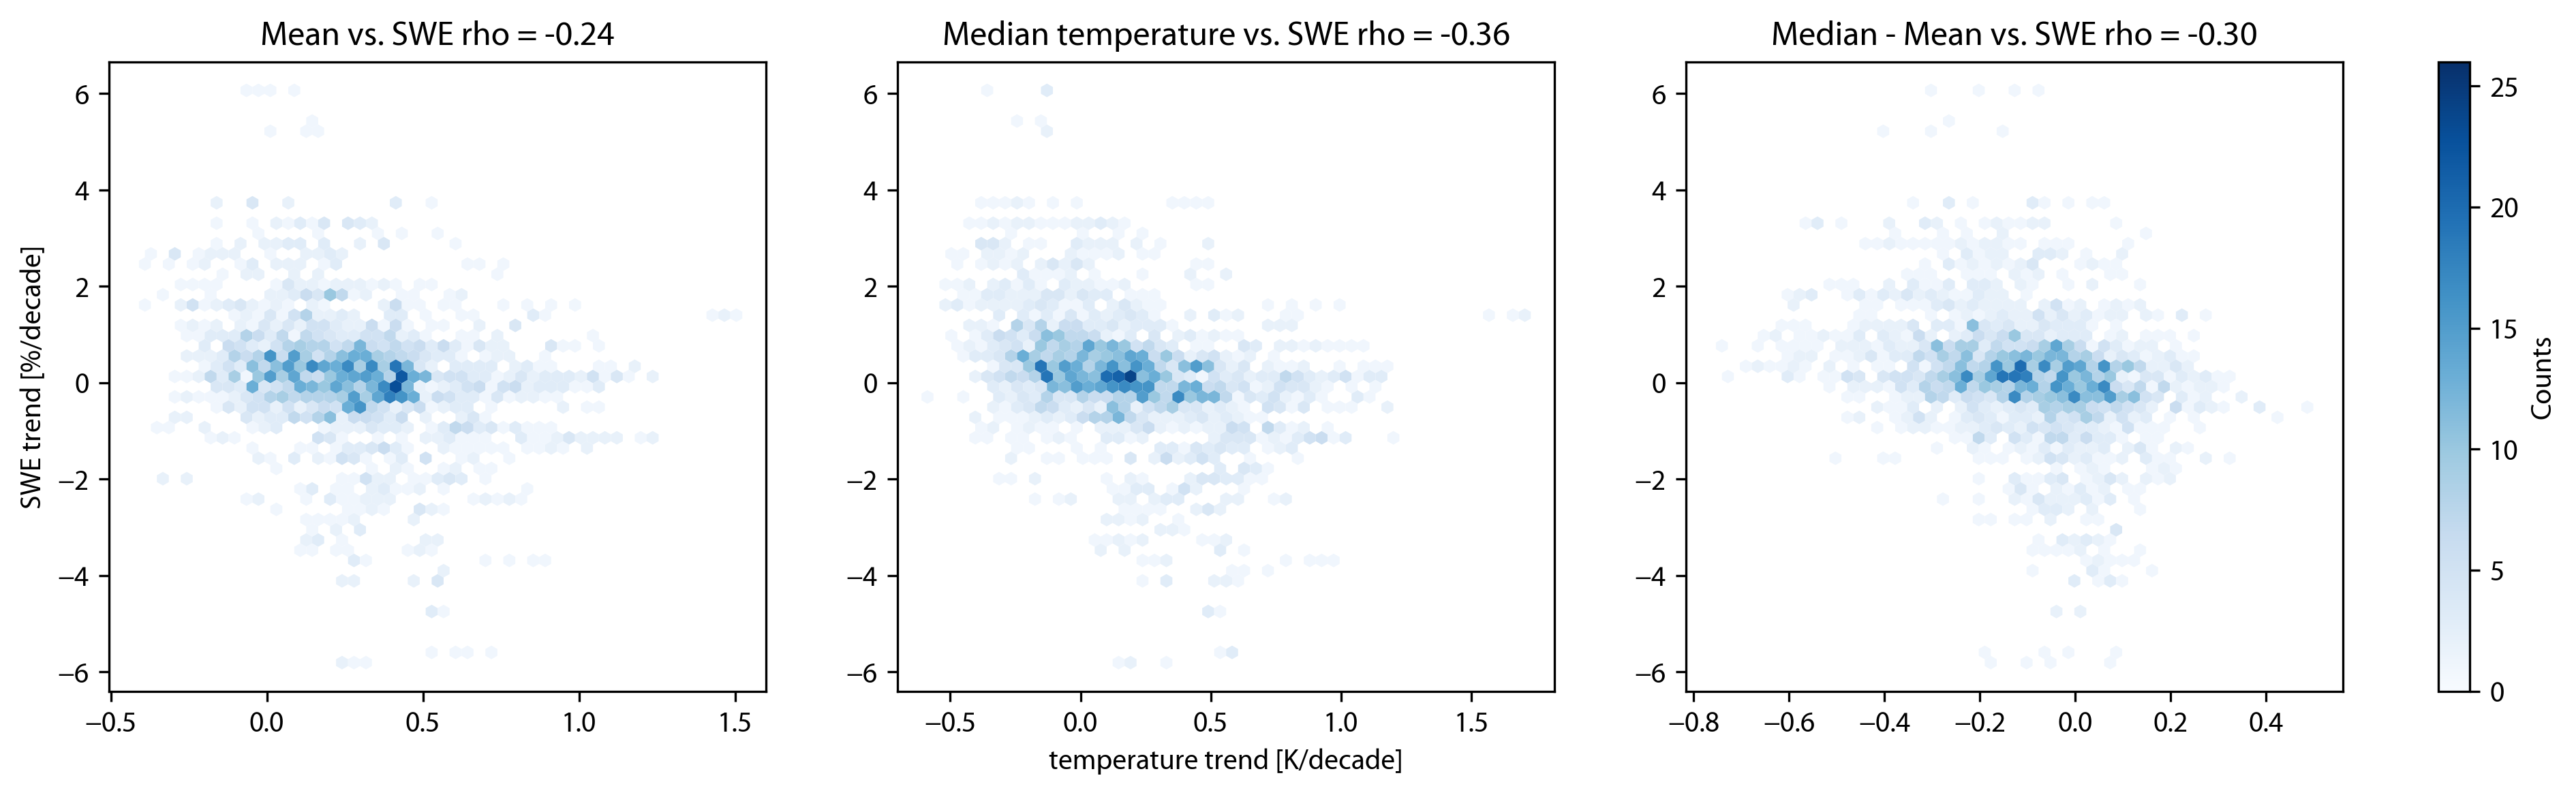

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

combined_density = np.concatenate([
    np.histogram2d(comp_insitu[:, 0], comp_insitu[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_insitu[:, 1], comp_insitu[:, 2], bins=50)[0].flatten(),
    np.histogram2d(comp_insitu[:, 1] - comp_insitu[:, 0], comp_insitu[:, 2], bins=50)[0].flatten()
])

max_density = combined_density.max()

hb = ax[0].hexbin(comp_insitu[:,0], comp_insitu[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[0].set_title('Mean vs. SWE rho = {:.2f}'.format(rho_mean_insitu))
ax[0].set_ylabel('SWE trend [%/decade]')

hb = ax[1].hexbin(comp_insitu[:,1], comp_insitu[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[1].set_title('Median temperature vs. SWE rho = {:.2f}'.format(rho_median_insitu))
ax[1].set_xlabel('temperature trend [K/decade]')

hb = ax[2].hexbin(comp_insitu[:,1] - comp_insitu[:,0], comp_insitu[:,2], gridsize=50, cmap='Blues', mincnt=1, vmin=0, vmax=max_density, linewidths=0)
ax[2].set_title('Median - Mean vs. SWE rho = {:.2f}'.format(rho_diff_insitu))

# Add a single colorbar for all plots
cbar = fig.colorbar(hb, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Counts')

# plt.tight_layout()
plt.show()

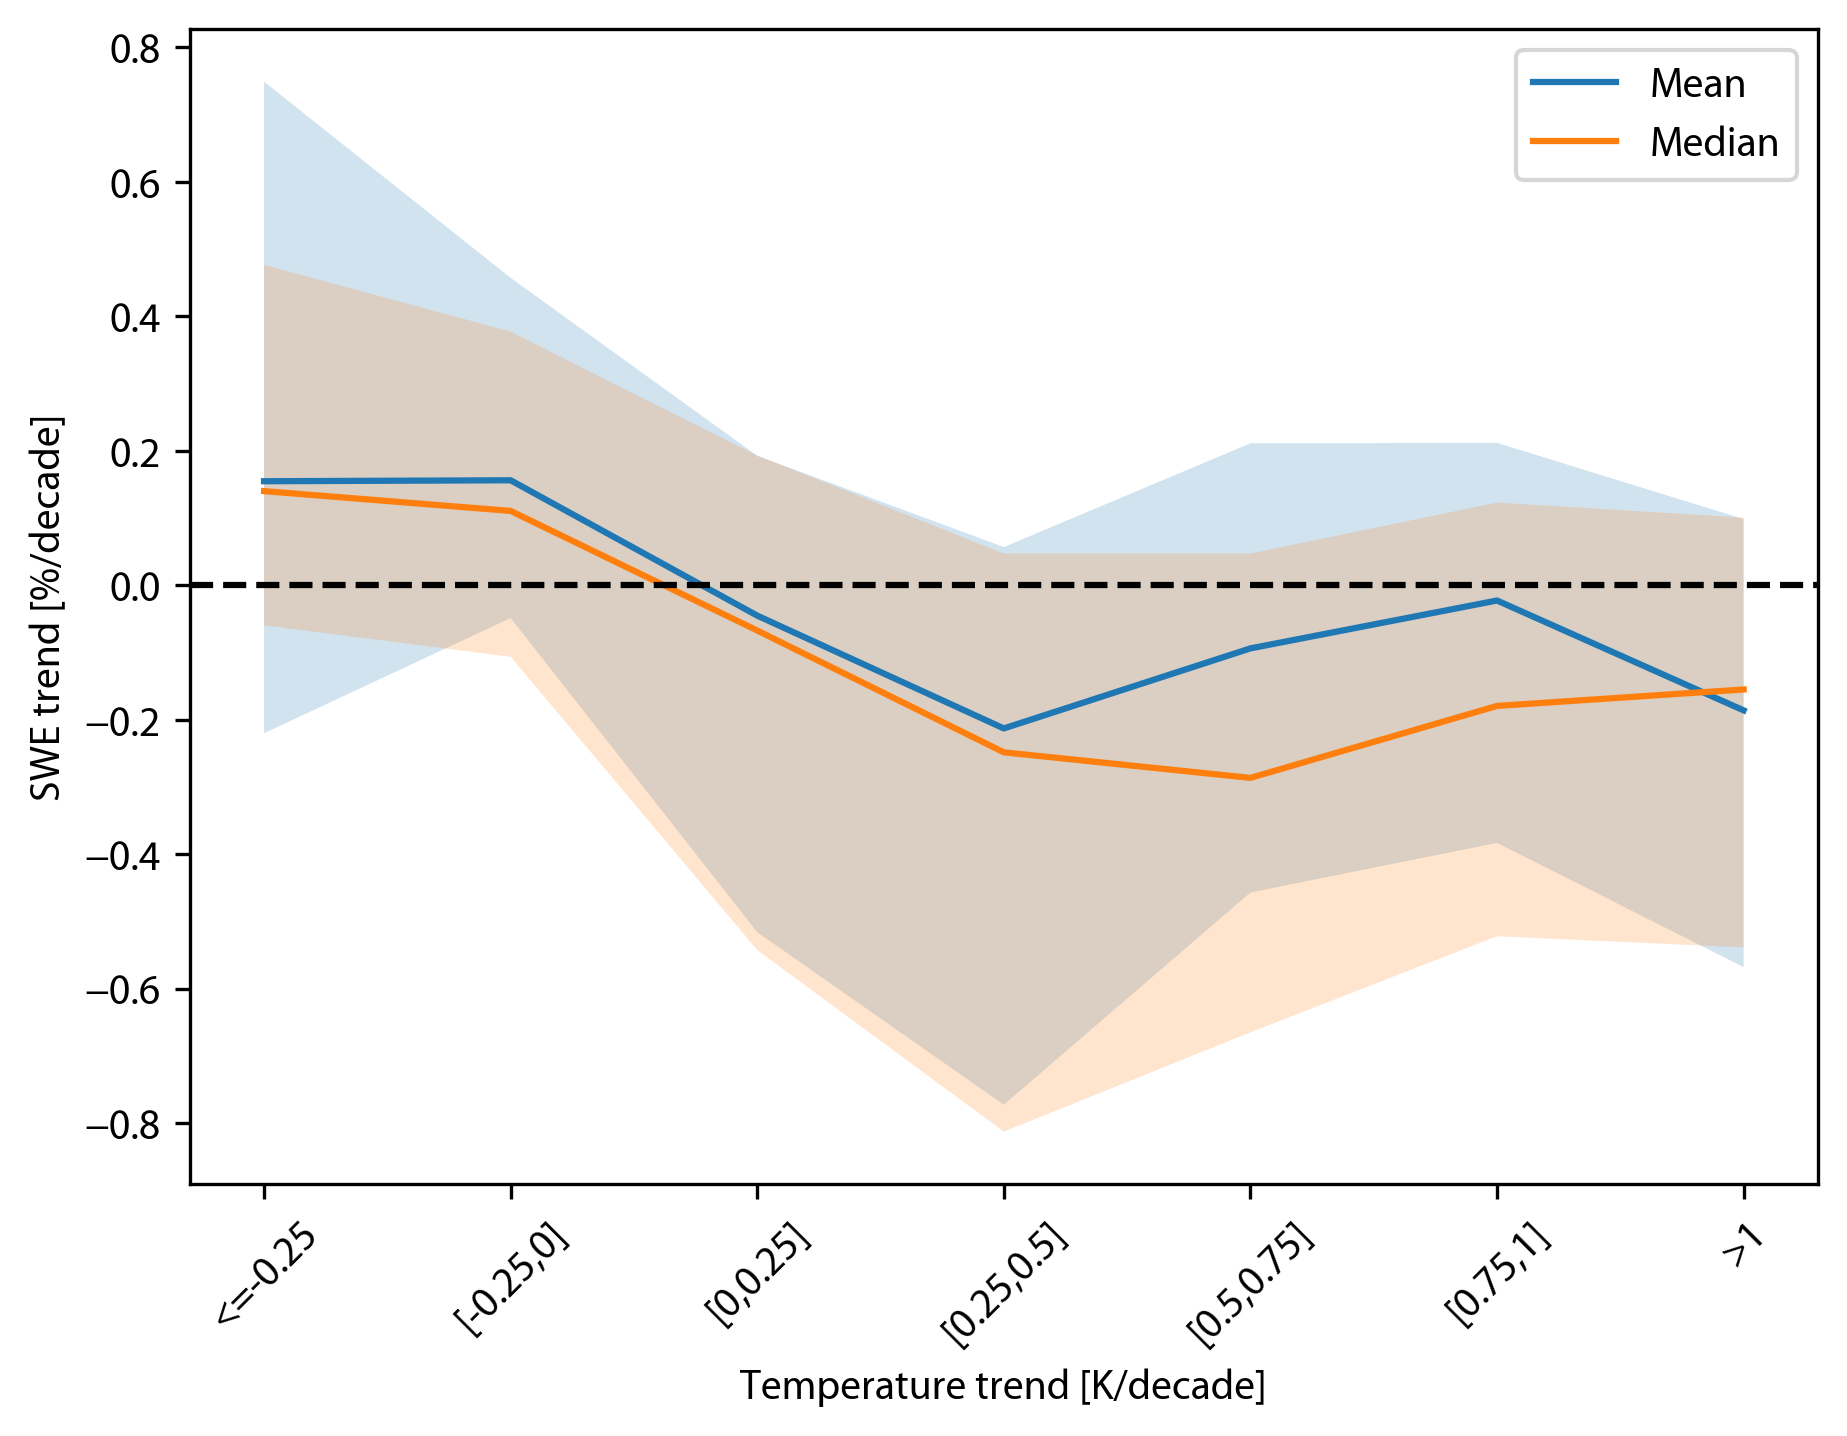

In [18]:
bins = [-0.25, 0, 0.25, 0.5, 0.75, 1]

label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

grouped_indices = np.digitize(comp_gridded[:,0], bins)
swe_group = {}
for i in range(len(bins)+1):
    swe_group[i] = []

for idx, group_id in enumerate(grouped_indices):
    swe_group[group_id].append(comp_gridded[idx,2])

swe_mid = []
swe_upp = []
swe_low = []

for i in range(len(bins)+1):
    swe_mid.append(np.median(swe_group[i]))
    swe_upp.append(np.percentile(swe_group[i], 75))
    swe_low.append(np.percentile(swe_group[i], 25))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(np.arange(len(bins)+1), swe_mid, label='Mean')
ax.fill_between(np.arange(len(bins)+1), swe_low, swe_upp, alpha=0.2)


grouped_indices = np.digitize(comp_gridded[:,1], bins)
swe_group = {}
for i in range(len(bins)+1):
    swe_group[i] = []

for idx, group_id in enumerate(grouped_indices):
    swe_group[group_id].append(comp_gridded[idx,2])

swe_mid = []
swe_upp = []
swe_low = []

for i in range(len(bins)+1):
    swe_mid.append(np.median(swe_group[i]))
    swe_upp.append(np.percentile(swe_group[i], 75))
    swe_low.append(np.percentile(swe_group[i], 25))

ax.plot(np.arange(len(bins)+1), swe_mid, label='Median')
ax.fill_between(np.arange(len(bins)+1), swe_low, swe_upp, alpha=0.2)

ax.set_xticks(np.arange(len(bins)+1))
ax.set_xticklabels(label_str)
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_ylabel('SWE trend [%/decade]')
ax.set_xlabel('Temperature trend [K/decade]')

ax.axline((0, 0), slope=0, color='black', linestyle='--')





